# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
#Box 2 - Load in the data frames
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep= ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv' , sep=';')

azdias_untouched = azdias



In [33]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

#Evaluating the structure of azdias
print(azdias.head (n=10))
print(azdias.shape)
print(azdias.describe())
print(azdias.info())

#Evaluating the structure of azdias_feat_info
print(feat_info.head (n=10))
print(feat_info.shape)
print(feat_info.describe())
print(feat_info.info())



   AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   
5         3                     1          2            2.0   
6        -1                     2          2            5.0   
7        -1                     1          1            3.0   
8        -1                     3          1            3.0   
9        -1                     3          2            4.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3             

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [139]:
# 1.1 Identify missing or unknown data values and convert them to NaNs. I will start by counting them.
Nulls_in_azdias = azdias.isnull().sum().sum()
print("There are currently {} missing data items in azdias accross the data set".format(Nulls_in_azdias))



There are currently 4896838 missing data items in azdias accross the data set


In [35]:
# Match the additional null designations from feat_info, iterate over the columns and replace hits with NaNs

#Iterate over the columns
for col in range(azdias.shape[1]):
    col_ref=azdias.columns[col]
    
    #Reference the feat_info key
    null_key=feat_info.iloc[col,3]
    
    #Clean up the feata_info key
    null_key=null_key.replace('[', '')
    null_key=null_key.replace(']', '')
    null_key=null_key.split(',')
    
    #Replace the value
    #Start by skipping over feat_info with no null values
    if null_key == ['']:
        continue
    
    #Then look for object types which can be fed directly into replace
    else:
        for ref_null in null_key:
            if azdias[col_ref].dtype =='object':
                azdias.loc[azdias[col_ref]==ref_null,col_ref]=np.nan 
            
            #Then convert the integer based keys to integers so replace can read it
            else:  
                ref_null=int(ref_null)
                azdias.loc[azdias[col_ref]==ref_null,col_ref]=np.nan



In [36]:
# 1.1 Identify missing or unknown data values and convert them to NaNs. I will start by counting them.
Nulls_in_azdias = azdias.isnull().sum().sum()
print("There are currently {} missing data items in azdias accross the data set".format(Nulls_in_azdias))



There are currently 8373929 missing data items in azdias accross the data set


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [7]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

#I converted this to a percentage to get a better idea of what major thresholds are
length_of_data = len(azdias.iloc[:, 0:1])
sum_nulls = azdias.isnull().sum()
perc_nulls = sum_nulls / length_of_data





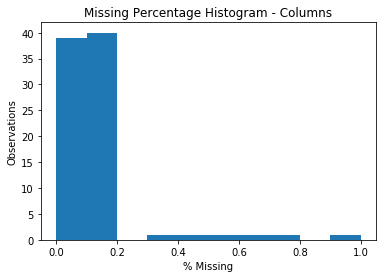

In [8]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(perc_nulls)

plt.title('Missing Percentage Histogram - Columns')
plt.ylabel('Observations')
plt.xlabel('% Missing')
plt.show()

In [9]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

#Here it appears that most columns have at least 80% of their data (<20% missing).
#While missing information might skew things a bit, removing too many columns could remove valuable information content
#Setting a rule to remove any column with <75% coverage seems prudent to me
#Having at least 80% of your data seems like a reasonable start and allows enough features from which to conduct further analysis

perc_nulls = sum_nulls / length_of_data
drop_columns=perc_nulls[perc_nulls>=.25].index
azdias.drop(columns=drop_columns,axis="columns",inplace=True)


In [9]:
print(drop_columns)

Index(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX'],
      dtype='object')


It's fairly clear from the histogram that there is a critical mass in which most data sets have at lest 80% coverage (<= 20% missing data items). Given the other columns were such outliers, I decided to remove the six columns that had more missing than this.

There 6 columns removed from the data due to insufficient observations ('AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP','KBA05_BAUMAX') appear to be fairly different.  Looking at the feat_info key above its hard to find a unifying them whether looking at type and/or the information_level given they are in different buckets.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

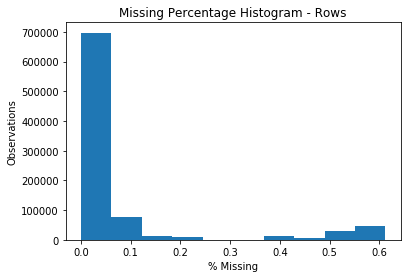

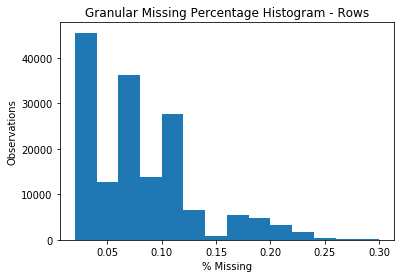

In [10]:
# How much data is missing in each row of the dataset?

number_row_nulls=azdias.isnull().sum(axis=1)
col_number = azdias.shape[1] + 1
perc_row_nulls = number_row_nulls / col_number

plt.hist(perc_row_nulls)

plt.title('Missing Percentage Histogram - Rows')
plt.ylabel('Observations')
plt.xlabel('% Missing')
plt.show()

#Looking in a more granular fashion
bin_list = [.02, .04, .06, .08, .10, .12, .14, .16, .18, .20, .22, .24, .26, .28, .3]

plt.hist(perc_row_nulls, bins = bin_list)

plt.title('Granular Missing Percentage Histogram - Rows')
plt.ylabel('Observations')
plt.xlabel('% Missing')
plt.show()

In [11]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

#It seems to me that there is a large gap around 30% which is what I chose as the dividing line
azdias_less_than_30 = azdias[perc_row_nulls<=.3]
azdias_greater_than_30 = azdias[perc_row_nulls>.3]



In [12]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

#Lets take the perc_null formula, created later and simply sort the data and limit it to the top 5
perc_nulls.sort_values(ascending=True,inplace=True)
cols_for_graphs = perc_nulls.iloc[:5].index
print(perc_nulls.iloc[:5])
#Note, I am aware that there are more columns with zero nulls, but for the purposes of this assignment I will not be exploring the differences at this juncture.


ZABEOTYP         0.0
SEMIO_TRADV      0.0
SEMIO_PFLICHT    0.0
SEMIO_KAEM       0.0
SEMIO_DOM        0.0
dtype: float64


In [25]:
#From here I will generate the requested comparison charts

def seaborn_count_plots(column):
    
    #Set plot parameters
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(25)
    
    #Set first plot of stocks with lots of missing observations(I prefer horizontal bars)
    ax1.set_title('Rows With > 30% Observations Missing')
    sns.countplot(azdias.loc[azdias_greater_than_30.index,column],ax=ax1,orient="h")

    #Set second plot wtih few missing observations(I prefer horizontal bars)
    ax2.set_title('Rows With < 30% Observations Missing')
    sns.countplot(azdias.loc[azdias_less_than_30.index,column],ax=ax2, orient ="h")
    
    plt.show()



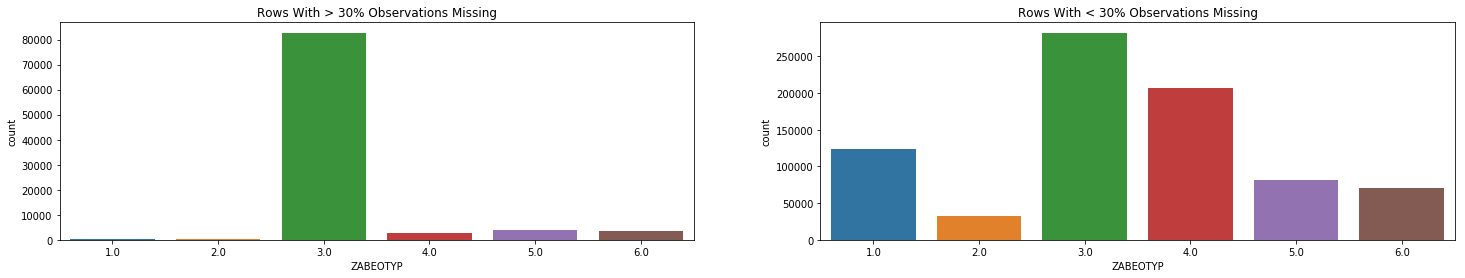

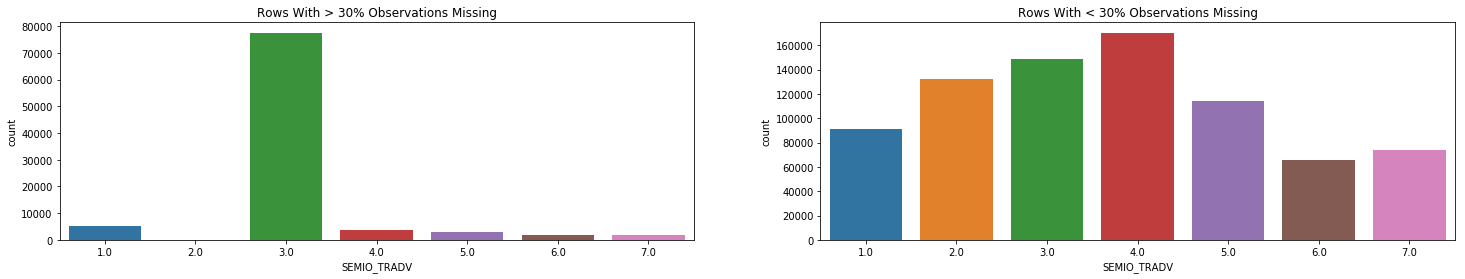

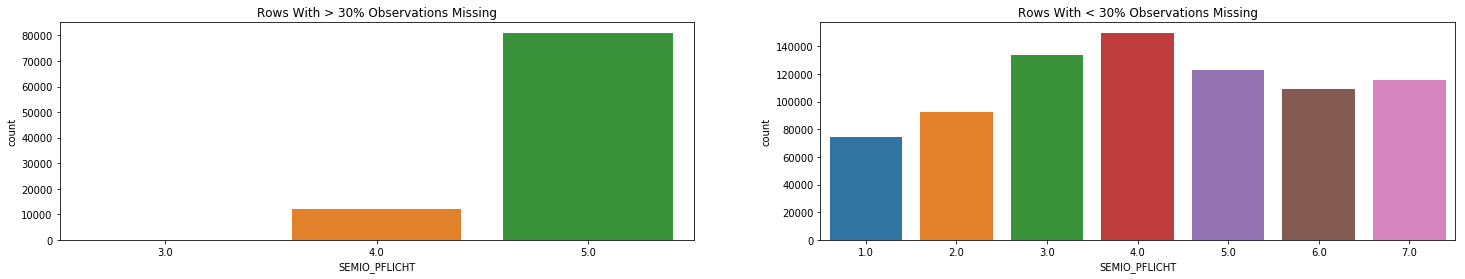

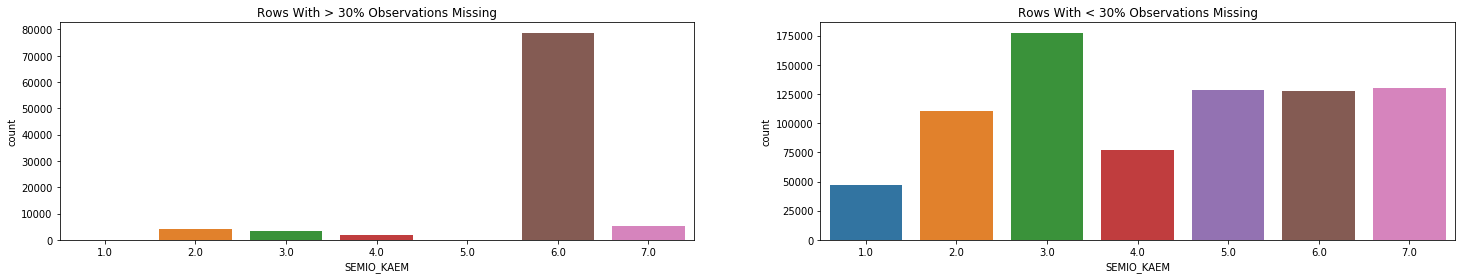

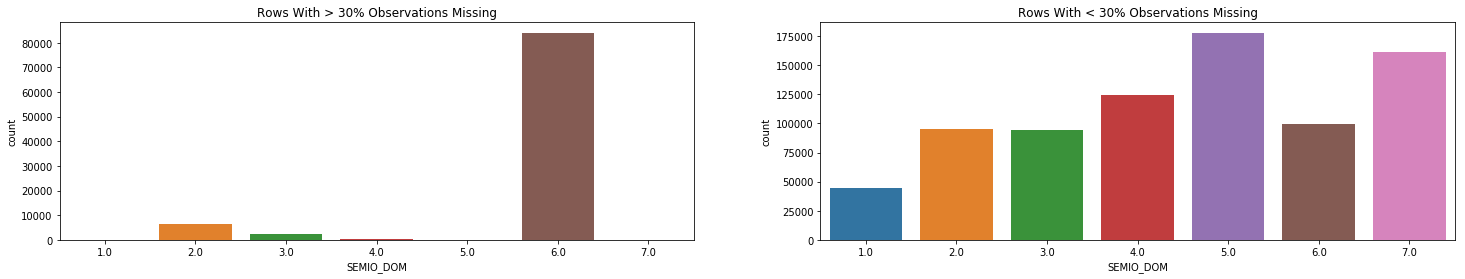

In [26]:
#Run the columns throuh the graph
for i in cols_for_graphs:
    seaborn_count_plots(i)

Yes.  The tendency at least for the columns i am evaluating is that the rows with lots of missing observations tend to coalesce around one dominant specific value (3, 3, 5, 6, 6 respectively) whereas the other rows have more evenly dispersed observations.

If anything this speaks to some potential bias in the rows that have lots of nulls re-enforcing my decision to remove them from the dataset.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [150]:
# How many features are there of each data type?

feat_info = feat_info[feat_info.attribute.isin(list(azdias.columns.values))]
print(feat_info['type'].value_counts())


ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64


In [ ]:
#From the above list it appears that the vast majority of data falls under the ordinal and numeric categories (54) 
#The other data (mixed and categorical) will need to be one hot encoded per the instructions if desired.

In [151]:
print(azdias.columns)

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP',
       'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
       'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S',
       'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT',
       'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT',
       'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'ANZ_PERSONEN',
       'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015',
       'CAMEO

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [13]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

#Seperate the columns which are categorical 
categorical_columns = feat_info[feat_info.type=='categorical']

#Index the categorical and isolate the column name
categorical_column_index = feat_info[feat_info.type=='categorical'].index
categorical_column_label = feat_info['attribute'][categorical_column_index]

#Determine if the mixed and categorical data is now in azdias after dropping some N/A columns
categorical_column_label = categorical_column_label[categorical_column_label.isin(azdias)==1]

#Adjust the columns to remove those no longer in azdias
print(categorical_column_label)


2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
41            VERS_TYP
42            ZABEOTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object


In [14]:
for col in categorical_column_label:
    print(azdias[col].value_counts())

2.0    465305
1.0    425916
Name: ANREDE_KZ, dtype: int64
4.0    210963
3.0    156449
6.0    153915
2.0    148795
5.0    117376
1.0     98869
Name: CJT_GESAMTTYP, dtype: int64
6.0    290367
1.0    199572
4.0    130625
2.0    110867
5.0    106436
3.0     53354
Name: FINANZTYP, dtype: int64
12.0    138545
5.0     120126
10.0    109127
8.0      88042
11.0     79740
4.0      63770
9.0      60614
3.0      56007
1.0      53600
2.0      46702
7.0      42956
6.0      27138
Name: GFK_URLAUBERTYP, dtype: int64
0    715996
1    175225
Name: GREEN_AVANTGARDE, dtype: int64
1.0     426379
10.0    137913
2.0     104305
11.0     51719
8.0      23032
7.0      20730
4.0      12303
5.0      11920
9.0      11148
6.0       9022
3.0       4958
Name: LP_FAMILIE_FEIN, dtype: int64
1.0    426379
5.0    200780
2.0    104305
4.0     52784
3.0     29181
Name: LP_FAMILIE_GROB, dtype: int64
1.0     219275
9.0     143238
2.0     118236
10.0    118022
4.0      78317
5.0      74493
3.0      74105
6.0      30914
8.0   

In [15]:
def column_sorter():
    
    #Setup a list which will contain column names for columns with multiple binary variables
    col_list = []
    
    #Iterate through the already specified categorical and mixed columns list from above
    for col in categorical_column_label:
        
        #Identify and skip the columns already removed from azdias
        if len(azdias[col].value_counts())>2:
            col_list.append(col)
            
        else:
            continue
            
                
    return pd.get_dummies(azdias, columns = col_list)
          
            

In [16]:
column_sorter()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
0,2.0,1.0,3.0,4.0,3.0,5.0,5.0,3.0,0,NaN,...,0,0,0,0,0,0,0,0,0,0
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0,3.0,...,0,1,0,0,0,0,0,0,0,0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1,3.0,...,0,0,0,0,0,0,0,0,0,0
3,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0,2.0,...,0,0,0,0,0,0,0,0,0,0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0,3.0,...,0,0,0,0,0,0,0,0,0,0
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0,3.0,...,0,0,0,1,0,0,0,0,0,0
6,2.0,2.0,1.0,5.0,1.0,5.0,4.0,3.0,0,2.0,...,0,0,0,0,0,0,0,0,0,0
7,1.0,1.0,3.0,3.0,4.0,1.0,3.0,2.0,0,1.0,...,0,0,0,0,0,0,0,0,0,0
8,3.0,1.0,4.0,4.0,2.0,4.0,2.0,2.0,1,3.0,...,0,0,0,0,0,0,0,0,0,0
9,3.0,2.0,2.0,4.0,2.0,3.0,5.0,4.0,1,2.0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#The above formula should have sorted the columns with multi-variables and one hot encoded them

In [158]:
print(azdias.CAMEO_DEUG_2015[0:20])

0     NaN
1       8
2       4
3       2
4       6
5       8
6       4
7       2
8       1
9       1
10      9
11    NaN
12      6
13      5
14    NaN
15      8
16      7
17    NaN
18      4
19      5
Name: CAMEO_DEUG_2015, dtype: object


I decided to keep all of the categorical variables now that we've been able to one hot encode them all.  I've already removed columns with too many nulls at this point and the remaining columns could have valuable information content which will be revealed in the principal component analysis later.  No sense in removing them if they can be potentially useful and are prepped for inputting into a model.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [17]:
#First lets just get a summary of the mixed_columns that are still in azdias after removals

#Identify mixed_columns
mixed_columns = feat_info[feat_info.type=='mixed']

#Index the mixed columns and isolate the column name
mixed_columns_index = feat_info[feat_info.type=='mixed'].index
mixed_column_label = feat_info['attribute'][mixed_columns_index]

#Determine if the mixed data is now in azdias after dropping some N/A columns
mixed_column_label = mixed_column_label[mixed_column_label.isin(azdias)==1]

#Adjust the columns to remove those no longer in azdias
print(mixed_column_label)

15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
79              PLZ8_BAUMAX
Name: attribute, dtype: object


In [17]:
for col in mixed_column_label:
    print(azdias[col].value_counts())

1.0     62667
5.0     55542
6.0     45614
2.0     39434
8.0     30475
11.0    26710
29.0    26577
7.0     26508
13.0    26085
10.0    25789
31.0    23987
12.0    23300
30.0    22361
15.0    20062
3.0     19985
19.0    19484
37.0    18525
4.0     17595
14.0    17529
20.0    17132
32.0    17105
39.0    16182
40.0    15150
27.0    14475
16.0    14466
38.0    13914
35.0    13679
34.0    13074
9.0     13066
21.0    12766
28.0    12264
24.0    12091
36.0    10505
25.0    10370
23.0     9191
22.0     7224
18.0     7168
33.0     6066
17.0     5888
26.0     3584
Name: LP_LEBENSPHASE_FEIN, dtype: int64
2.0     158139
1.0     139681
3.0     115624
12.0     74276
4.0      54443
5.0      49672
9.0      48938
10.0     41092
11.0     32819
8.0      30323
6.0      29181
7.0      22461
Name: LP_LEBENSPHASE_GROB, dtype: int64
14.0    188697
8.0     145988
5.0      86416
10.0     85808
3.0      55195
15.0     42547
11.0     35752
9.0      33570
6.0      25652
12.0     24446
1.0      21282
4.0      20451


In [ ]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables. Part 1 Reference
#Divide by decades and movement type
### 1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [18]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables Part II

#Take the two features (decade and movement) and re-assign values based on a dictionary
movement_dictionary ={1:1,2:0,3:1,4:0,5:1,6:0,7:0,8:1,9:0,10:1,11:0,12:1,13:0,14:1,15:0}
decade_dictionary={1:1,2:1,3:2,4:2,5:3,6:3,7:3,8:4,9:4,10:5,11:5,12:5,13:5,14:6,15:6}

#Setup two new columns 
azdias['PJ_Movement'] = azdias['PRAEGENDE_JUGENDJAHRE']
azdias['PJ_Decade'] = azdias['PRAEGENDE_JUGENDJAHRE']

#Replace the old values in from the PJ Column with the pre-defined dictionaries
azdias['PJ_Movement'].replace(movement_dictionary,inplace=True)
azdias['PJ_Decade'].replace(decade_dictionary,inplace=True)

#Drop the old column from the dataset
azdias.drop("PRAEGENDE_JUGENDJAHRE",axis=1,inplace=True)

print(azdias.columns)

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP',
       'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
       'NATIONALITAET_KZ', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM',
       'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL',
       'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM',
       'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP',
       'ZABEOTYP', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE',
       'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV',
       'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR',
       'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015',
       'CAMEO_INTL_2

In [ ]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

### 4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown



In [19]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

#Take the two features (decade and movement) and re-assign values based on a dictionary
Wealth_dictionary ={'11':1,'12':1,'13':1,'14':1,'15':1,'21':2,'22':2,'23':2,'24':2,'25':2,'31':3,'32':3,'33':3,'34':3,'35':3,'41':4,'42':4,'43':4,'44':4,'45':4,'51':5,'52':5,'53':5,'54':5,'55':5}
Life_stage_dictionary ={'11':1,'12':2,'13':3,'14':4,'15':5,'21':1,'22':2,'23':3,'24':4,'25':5, '31':1,'32':2,'33':4,'34':4,'35':5,'41':1,'42':2,'43':3,'44':4,'45':5,'51':1,'52':2,'53':3,'54':4,'55':5}

#Setup two new columns 
azdias['CAMEO_Wealth'] = azdias['CAMEO_INTL_2015']
azdias['CAMEO_Life_Stage'] = azdias['CAMEO_INTL_2015']

#Replace the old values in from the PJ Column with the pre-defined dictionaries
azdias['CAMEO_Wealth'].replace(Wealth_dictionary,inplace=True)
azdias['CAMEO_Life_Stage'].replace(Life_stage_dictionary,inplace=True)

azdias.drop("CAMEO_INTL_2015",axis=1,inplace=True)

print(azdias.columns)

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP',
       'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
       'NATIONALITAET_KZ', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM',
       'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL',
       'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM',
       'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP',
       'ZABEOTYP', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE',
       'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV',
       'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR',
       'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015',
       'KBA05_ANTG1'

In [20]:
print(mixed_column_label)

15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
79              PLZ8_BAUMAX
Name: attribute, dtype: object


In [20]:
#Finally I am going to drop all the other mixed columns 

azdias.drop("LP_LEBENSPHASE_FEIN",axis=1,inplace=True)
azdias.drop("LP_LEBENSPHASE_GROB",axis=1,inplace=True)
azdias.drop("WOHNLAGE",axis=1,inplace=True)
azdias.drop("PLZ8_BAUMAX",axis=1,inplace=True)
azdias.drop("CAMEO_DEU_2015",axis=1,inplace=True)
#azdias.drop("PLZ8_BAUMAX",axis=1,inplace=True)
azdias.drop("OST_WEST_KZ",axis=1,inplace=True)



I decided to re-engineer the two suggested above and then remove the remainder of the mixed features.  The first reason is it's unclear if the juice is worth the squeeze given all the manual work which needs to be done to look across different axis.  The second aspect is there was a fair amount of overlap in the data because there were multiple references to age which is highly related to decade born and the stage in the life cycle as well as allusions to income which is likely covered elsewhere. 

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [21]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
number_row_nulls=azdias.isnull().sum(axis=1)
col_number = azdias.shape[1] + 1
perc_row_nulls = number_row_nulls / col_number
final_data = azdias[perc_row_nulls<=.3]




In [22]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

remaining_mixed = []

mixed_variable_label=feat_info[feat_info['type'] =="mixed"]
for mixed_col in mixed_variable_label["attribute"]:
    if mixed_col in final_data:
        remaining_mixed.append(mixed_col)

In [23]:
print(remaining_mixed)

[]


In [24]:
#Check final columns
data = final_data.columns
print(data)

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP',
       'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
       'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'RETOURTYP_BK_S', 'SEMIO_SOZ',
       'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST',
       'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM',
       'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SHOPPER_TYP', 'SOHO_KZ',
       'VERS_TYP', 'ZABEOTYP', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'CAMEO_DEUG_2015', 'KBA05_ANTG1', 'KBA05_ANTG2',
       'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE',
       'INNENS

In [25]:
final_data.shape

(797940, 75)

In [26]:
for col in final_data.columns:
    print(final_data[col].value_counts())

3.0    310398
4.0    223230
2.0    137093
1.0    124418
Name: ALTERSKATEGORIE_GROB, dtype: int64
2.0    416101
1.0    381839
Name: ANREDE_KZ, dtype: int64
4.0    198278
3.0    147203
2.0    141260
5.0    111106
6.0    102076
1.0     93306
Name: CJT_GESAMTTYP, dtype: int64
3.0    180611
5.0    161243
4.0    159624
2.0    157814
1.0    138648
Name: FINANZ_MINIMALIST, dtype: int64
1.0    244211
2.0    148879
5.0    143883
3.0    138057
4.0    122910
Name: FINANZ_SPARER, dtype: int64
5.0    235979
4.0    192724
3.0    153182
2.0    112856
1.0    103199
Name: FINANZ_VORSORGER, dtype: int64
1.0    208550
2.0    158202
5.0    155088
4.0    138164
3.0    137936
Name: FINANZ_ANLEGER, dtype: int64
1.0    220344
2.0    183837
3.0    161541
5.0    119527
4.0    112691
Name: FINANZ_UNAUFFAELLIGER, dtype: int64
5.0    183917
2.0    166326
3.0    157621
4.0    156614
1.0    133462
Name: FINANZ_HAUSBAUER, dtype: int64
6.0    289059
1.0    197118
5.0    106323
2.0    104748
4.0     55916
3.0     44776


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [8]:
def clean_data(data):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    
    # STEP1: convert missing value codes into NaNs, ...
    final_transform = data
    
    for col in range(final_transform.shape[1]):
        col_ref=final_transform.columns[col]

        #Reference the feat_info key
        null_key=feat_info.iloc[col,3]

        #Clean up the feata_info key
        null_key=null_key.replace('[', '')
        null_key=null_key.replace(']', '')
        null_key=null_key.split(',')

    #Replace the value
    #Start by skipping over feat_info with no null values
        if null_key == ['']:
            continue

        #Then look for object types which can be fed directly into replace
        else:
            for ref_null in null_key:
                if final_transform[col_ref].dtype =='object':
                    final_transform.loc[final_transform[col_ref]==ref_null,col_ref]=np.nan 

                #Then convert the integer based keys to integers so replace can read it
                else:  
                    if ref_null == 'X' or 'XX':
                        continue
                    else:
                        ref_null=int(ref_null)
                        final_transform.loc[final_transform[col_ref]==ref_null,col_ref]=np.nan
    
    
   
    #STEP2 remove selected columns and rows, ...
    
    #drop columns
    length_of_data = len(final_transform.iloc[:, 0:1])
    sum_nulls = final_transform.isnull().sum()
    perc_nulls = sum_nulls / length_of_data
    drop_columns=perc_nulls[perc_nulls>=.25].index
    final_transform.drop(columns=drop_columns,axis="columns",inplace=True)
    
    
    #drop rows
    number_row_nulls=final_transform.isnull().sum(axis=1)
    col_number = final_transform.shape[1] + 1
    perc_row_nulls = number_row_nulls / col_number
    final_transform = final_transform[perc_row_nulls<=.3]
    
    #STEP3 select, re-encode, and engineer column values.
    
    #Seperate the columns which are categorical 
    categorical_columns = feat_info[feat_info.type=='categorical']

    #Index the categorical and isolate the column name
    categorical_column_index = feat_info[feat_info.type=='categorical'].index
    categorical_column_label = feat_info['attribute'][categorical_column_index]

    #Determine if the mixed and categorical data is now in azdias after dropping some N/A columns
    categorical_column_label = categorical_column_label[categorical_column_label.isin(final_transform)==1]
    
    
        
    #Define column_sorter function
    def column_sorter():
    
        #Setup a list which will contain column names for columns with multiple binary variables
        col_list = []

        #Iterate through the already specified categorical and mixed columns list from above
        for col in categorical_column_label:

            #Identify and skip the columns already removed from azdias
            if len(final_transform[col].value_counts())>2:
                col_list.append(col)

            else:
                continue

        pd.get_dummies(data=final_transform,columns=col_list)
        
    
    #Run function 
    column_sorter()
   
  
    #Re-engineer "PRAEGENDE_JUGENDJAHRE"
    
    #Take the two features (decade and movement) and re-assign values based on a dictionary
    movement_dictionary ={1:1,2:0,3:1,4:0,5:1,6:0,7:0,8:1,9:0,10:1,11:0,12:1,13:0,14:1,15:0}
    decade_dictionary={1:1,2:1,3:2,4:2,5:3,6:3,7:3,8:4,9:4,10:5,11:5,12:5,13:5,14:6,15:6}

    #Setup two new columns 
    final_transform["PJ_Movement"] = final_transform.PRAEGENDE_JUGENDJAHRE
    final_transform["PJ_Decade"] = final_transform.PRAEGENDE_JUGENDJAHRE

    #Replace the old values in from the PJ Column with the pre-defined dictionaries
    final_transform["PJ_Movement"].replace(movement_dictionary,inplace=True)
    final_transform["PJ_Decade"].replace(decade_dictionary,inplace=True)

    #Re-engineer "CAMEO_INTL_2015"
    Wealth_dictionary ={'11':1,'12':1,'13':1,'14':1,'15':1,'21':2,'22':2,'23':2,'24':2,'25':2,'31':3,'32':3,'33':3,'34':3,'35':3,'41':4,'42':4,'43':4,'44':4,'45':4,'51':5,'52':5,'53':5,'54':5,'55':5}
    Life_stage_dictionary ={'11':1,'12':2,'13':3,'14':4,'15':5,'21':1,'22':2,'23':3,'24':4,'25':5, '31':1,'32':2,'33':4,'34':4,'35':5,'41':1,'42':2,'43':3,'44':4,'45':5,'51':1,'52':2,'53':3,'54':4,'55':5}

    #Setup two new columns 
    final_transform["CAMEO_Wealth"] = final_transform.CAMEO_INTL_2015
    final_transform["CAMEO_Life_Stage"] = final_transform.CAMEO_INTL_2015

    #Replace the old values in from the PJ Column with the pre-defined dictionaries
    final_transform['CAMEO_Wealth'].replace(Wealth_dictionary,inplace=True)
    final_transform['CAMEO_Life_Stage'].replace(Life_stage_dictionary,inplace=True)

    #Create a list of columns to drop
    dropcol_list = ['CAMEO_INTL_2015', 'PRAEGENDE_JUGENDJAHRE', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX', 'CAMEO_DEU_2015']
    final_transform.drop(columns=dropcol_list,axis=1,inplace=True)
    
    #One off change to 
    OST_WEST_Dict = {'W':1, 'O':0}
    final_transform['OST_WEST_KZ'].replace(OST_WEST_Dict,inplace=True)
        
    # Return the cleaned dataframe.
    return final_transform
    

In [9]:
final_data = clean_data(azdias_untouched)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/opt/conda/

In [10]:
final_data.shape
final_data.columns

Index(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
       'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'RETOURTYP_BK_S', 'SEMIO_SOZ',
       'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST',
       'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM',
       'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SHOPPER_TYP', 'SOHO_KZ',
       'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP', 'ALTER_HH', 'ANZ_PERSONEN',
       'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'KBA05_ANTG1',
       'KBA05_ANTG2', 'KBA05_ANTG3', 

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [11]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

#Fill in relevant dataframe here 
pca_data = final_data
clean_pca_data = pca_data.dropna()
clean_pca_data.shape



(697612, 81)

In [7]:
for col in clean_pca_data.columns:
    print(clean_pca_data[col].value_counts())

-1    512076
 2     83334
 1     71892
 3     23068
 0      7242
Name: AGER_TYP, dtype: int64
3    271910
4    194800
2    119789
1    108670
9      2443
Name: ALTERSKATEGORIE_GROB, dtype: int64
2    364400
1    333212
Name: ANREDE_KZ, dtype: int64
4.0    174650
3.0    130517
2.0    124277
5.0     98851
6.0     88907
1.0     80410
Name: CJT_GESAMTTYP, dtype: int64
3    160129
2    142397
5    136328
4    133544
1    125214
Name: FINANZ_MINIMALIST, dtype: int64
1    214350
5    129885
2    127848
3    122837
4    102692
Name: FINANZ_SPARER, dtype: int64
5    208158
4    167763
3    133639
2     98227
1     89825
Name: FINANZ_VORSORGER, dtype: int64
1    183319
2    138039
5    135737
4    120492
3    120025
Name: FINANZ_ANLEGER, dtype: int64
1    201733
2    165192
3    134089
4    101257
5     95341
Name: FINANZ_UNAUFFAELLIGER, dtype: int64
5    168331
2    144681
3    143301
4    143147
1     98152
Name: FINANZ_HAUSBAUER, dtype: int64
6    262706
1    174914
5     94520
2     88518
4 

In [12]:
# Apply feature scaling to the general population demographics data.
scaler =StandardScaler()
clean_pca_data_scaled = scaler.fit_transform(clean_pca_data)



Don't quite know what to write here other than I made sure to just drop n/a as there were still many observations left and I went with the recommmended standard_scalar function which provides a normal distribution. Getting more conceptual this will provide more information content than a simple min/max scaler but will be subject to distortion by outliers.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [13]:
# Apply PCA to the data.
pca = PCA()
pca.fit(clean_pca_data_scaled)


PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

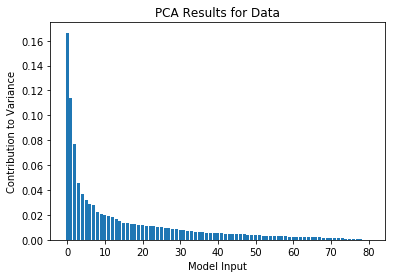

[  1.66430170e-01   1.13687419e-01   7.69499110e-02   4.56800326e-02
   3.66311954e-02   3.22381292e-02   2.90621669e-02   2.78531980e-02
   2.24962757e-02   2.09643672e-02   1.99260198e-02   1.92870451e-02
   1.85853983e-02   1.68941153e-02   1.49461602e-02   1.35090512e-02
   1.33953731e-02   1.23817734e-02   1.23360367e-02   1.22394674e-02
   1.17415089e-02   1.13312387e-02   1.08735281e-02   1.07284000e-02
   1.03141114e-02   1.01142399e-02   9.86840137e-03   9.47306757e-03
   8.99145007e-03   8.53415841e-03   7.88506998e-03   7.51122315e-03
   6.98683492e-03   6.71216311e-03   6.45385731e-03   6.34357749e-03
   6.26355151e-03   5.81696994e-03   5.74890332e-03   5.47004203e-03
   5.37897251e-03   5.23713686e-03   5.03797549e-03   4.81627937e-03
   4.65974313e-03   4.60333000e-03   4.41202448e-03   4.35874802e-03
   4.13344974e-03   3.81551892e-03   3.64269086e-03   3.48742518e-03
   3.36911092e-03   3.15922306e-03   3.04549353e-03   2.95197924e-03
   2.89466023e-03   2.81700189e-03

In [10]:
# Investigate the variance accounted for by each principal component.

pca_components=np.arange(len(pca.explained_variance_ratio_))
values=pca.explained_variance_ratio_
plt.bar(pca_components,values)
plt.xlabel("Model Input")
plt.ylabel("Contribution to Variance")
plt.title("PCA Results for Data")
plt.show()

print(values)


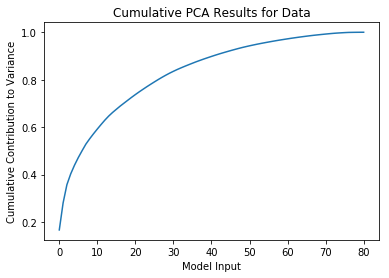

In [11]:
#A second visualization can help to determine what components will remain
cumulative_contributions = np.cumsum(values)
plt.plot(pca_components,cumulative_contributions)
plt.xlabel("Model Input")
plt.ylabel("Cumulative Contribution to Variance")
plt.title("Cumulative PCA Results for Data")
plt.show()



In [14]:
# Re-apply PCA to the data while selecting for number of components to retain.

#To me it seems as if the explanatory power of the model appears to level off around 60, thus I will use the first 60 components
trimmed_PCA_60 = PCA(n_components=60)
trimmed_PCA_data = trimmed_PCA_60.fit_transform(clean_pca_data_scaled)


I chose 60 features for the data.  After 60, the explanatory power of additional variables exhibited pronounced marginal diminishing returns.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [105]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def pca_component_result(n):
    '''
    The below function will re-arrange PCA results and display the top 5 and bottom 5
    n here is the number of the variable you would like to extract
    '''
    
    pca_data =pd.DataFrame(pca.components_[n])
    pca_data.index=final_data.columns
    pca_data.columns=['PC_' + str(n)]
    pca_data = pca_data.sort_values(by=['PC_' + str(n)], ascending=False)
    
    
    pca_plt = pd.concat([pca_data.head(5), pca_data.tail(5)])
    
    pca_plt.plot(kind='bar', title='Component # ' + str(n+1))
    ax = plt.gca()
    ax.grid(linewidth='0.5', alpha=0.5)
    ax.set_axisbelow(True)
    plt.show()


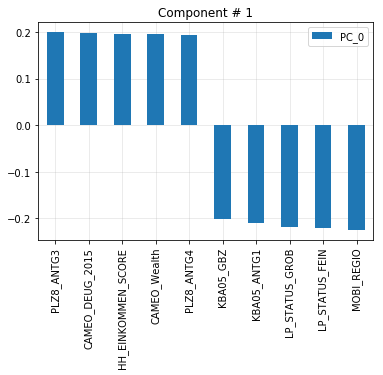

In [106]:
pca_component_result(0)

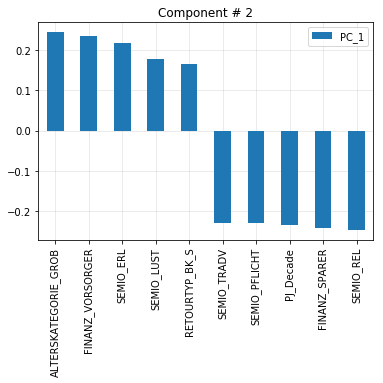

In [107]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_component_result(1)

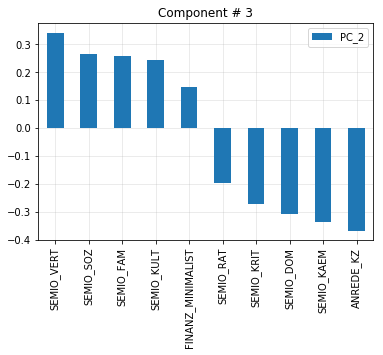

In [108]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_component_result(2)

Principal Component 1: Principal component one is all about wealth and income as the positive feature weights.  Addiitionally residential density is a strong positive feature weight.  The negative feature weights in many ways corroborate the wealth and income features. For example, the social status features which measure low to high class in various ways are inversely sorted relative to the income and wealth weights so it makes sense there is a negative relationship.  Additionally, low levels of financial interest and regional mobility are negative feature weights.

Principal Component 2: Principal component two is all about a person's age (age is a positive feature and the inverse of this (decade with oldest as 1) is a negative feature weight) and dare I say level of impetuousness/impulsiveness.  While there's no direct measure of impulsiveness some of the descriptors make sense - positive feature weights to event-orientation, low-financial preparedness, sensual-mindedness, return type? and negative feature weights to being traditional minded, dutiful, religious and savings oriented (in my experience this also ends to be consistent with the young vs the old)

Principal Component 3: Principal component 2 is all about demographics and personality affinitites.  It has positive feataure weights to age, social/family/cultural affinities and negative feature weights to rational/critical-minded/dominant-minded/combatitive affinities and being female.



## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

Text(0.5,1,'Cluster/Error Tradeoff Elbow Chart')

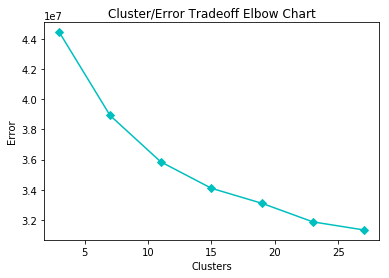

In [13]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.


def generate_kmeans(data, number):
    kmeans = KMeans(n_clusters=number)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    return score

scores = []
numbers = list(range(3,30,4))

for number in numbers:
    scores.append(generate_kmeans(trimmed_PCA_data, number))
    
plt.plot(numbers, scores, linestyle='-', marker='D', color='c');
plt.xlabel('Clusters');
plt.ylabel('Error');
plt.title('Cluster/Error Tradeoff Elbow Chart')



In [18]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters=20)
model = kmeans.fit(trimmed_PCA_data)
labels = model.predict(trimmed_PCA_data)



I decided to go with 20 clusters.  Per the elbow charts, continuing to segment up to 20 clusters reduces the variance by what seems like meaningful amount.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [3]:
# Load in the customer demographics data
final_data_run = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',sep=';')
final_data_run_test = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',sep=';')


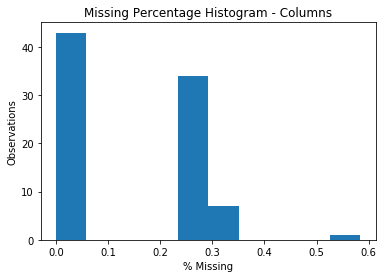

In [71]:
#Test N/A percentages for the new data
# STEP1: convert missing value codes into NaNs, ...
final_transform = final_data_run_test
    
for col in range(final_transform.shape[1]):
    col_ref=final_transform.columns[col]

    #Reference the feat_info key
    null_key=feat_info.iloc[col,3]

    #Clean up the feata_info key
    null_key=null_key.replace('[', '')
    null_key=null_key.replace(']', '')
    null_key=null_key.split(',')

    #Replace the value
    #Start by skipping over feat_info with no null values
    if null_key == ['']:
        continue

        #Then look for object types which can be fed directly into replace
    else:
        for ref_null in null_key:
            if final_transform[col_ref].dtype =='object':
                final_transform.loc[final_transform[col_ref]==ref_null,col_ref]=np.nan 

    #Then convert the integer based keys to integers so replace can read it
        else:  
            if ref_null == 'X' or 'XX':
                continue
            else:
                ref_null=int(ref_null)
                final_transform.loc[final_transform[col_ref]==ref_null,col_ref]=np.nan
    
#I converted this to a percentage to get a better idea of what major thresholds are
length_of_data = len(final_data_run_test.iloc[:, 0:1])
sum_nulls = final_data_run_test.isnull().sum()
perc_nulls = sum_nulls / length_of_data

#Investigate patterns in the amount of missing data in each column.
plt.hist(perc_nulls)
plt.title('Missing Percentage Histogram - Columns')
plt.ylabel('Observations')
plt.xlabel('% Missing')
plt.show()




In [72]:
#From the above you can see the #N/A percentage for the new data is higher than before.  As a result I'll have to rethink the data itsef.
#I will want to keep all the existing columns from the prior PCA analysis within reason
#Therefore I will check to see which columns might need to be dropped or imputed.
perc_nulls.sort_values(ascending=True,inplace=True)
print(perc_nulls.iloc[:85])

AGER_TYP                 0.000000
SEMIO_SOZ                0.000000
SEMIO_FAM                0.000000
SEMIO_REL                0.000000
SEMIO_MAT                0.000000
SEMIO_VERT               0.000000
SEMIO_LUST               0.000000
SEMIO_ERL                0.000000
PRAEGENDE_JUGENDJAHRE    0.000000
SEMIO_KULT               0.000000
SEMIO_KRIT               0.000000
SEMIO_DOM                0.000000
SEMIO_KAEM               0.000000
SEMIO_PFLICHT            0.000000
SEMIO_TRADV              0.000000
SHOPPER_TYP              0.000000
VERS_TYP                 0.000000
SEMIO_RAT                0.000000
NATIONALITAET_KZ         0.000000
ZABEOTYP                 0.000000
FINANZ_MINIMALIST        0.000000
ALTERSKATEGORIE_GROB     0.000000
ANREDE_KZ                0.000000
HEALTH_TYP               0.000000
GREEN_AVANTGARDE         0.000000
GEBURTSJAHR              0.000000
FINANZTYP                0.000000
FINANZ_HAUSBAUER         0.000000
FINANZ_UNAUFFAELLIGER    0.000000
FINANZ_ANLEGER

In [4]:
#Changed this function to create a higher threshold to remove columns (30% now).
#I will reconcile the columns used for the PCA and the remaining data here in the next step

def clean_data2(data):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    
    # STEP1: convert missing value codes into NaNs, ...
    final_transform = data
    
    for col in range(final_transform.shape[1]):
        col_ref=final_transform.columns[col]

        #Reference the feat_info key
        null_key=feat_info.iloc[col,3]

        #Clean up the feata_info key
        null_key=null_key.replace('[', '')
        null_key=null_key.replace(']', '')
        null_key=null_key.split(',')

    #Replace the value
    #Start by skipping over feat_info with no null values
        if null_key == ['']:
            continue

        #Then look for object types which can be fed directly into replace
        else:
            for ref_null in null_key:
                if final_transform[col_ref].dtype =='object':
                    final_transform.loc[final_transform[col_ref]==ref_null,col_ref]=np.nan 

                #Then convert the integer based keys to integers so replace can read it
                else:  
                    if ref_null == 'X' or 'XX':
                        continue
                    else:
                        ref_null=int(ref_null)
                        final_transform.loc[final_transform[col_ref]==ref_null,col_ref]=np.nan
    
    
   
    #STEP2 remove selected columns and rows, ...
    
    #drop columns
    length_of_data = len(final_transform.iloc[:, 0:1])
    sum_nulls = final_transform.isnull().sum()
    perc_nulls = sum_nulls / length_of_data
    drop_columns=perc_nulls[perc_nulls>=.3].index
    final_transform.drop(columns=drop_columns,axis="columns",inplace=True)
    
    
    #drop rows
    number_row_nulls=final_transform.isnull().sum(axis=1)
    col_number = final_transform.shape[1] + 1
    perc_row_nulls = number_row_nulls / col_number
    final_transform = final_transform[perc_row_nulls<=.3]
    
    #STEP3 select, re-encode, and engineer column values.
    
    #Seperate the columns which are categorical 
    categorical_columns = feat_info[feat_info.type=='categorical']

    #Index the categorical and isolate the column name
    categorical_column_index = feat_info[feat_info.type=='categorical'].index
    categorical_column_label = feat_info['attribute'][categorical_column_index]

    #Determine if the mixed and categorical data is now in azdias after dropping some N/A columns
    categorical_column_label = categorical_column_label[categorical_column_label.isin(final_transform)==1]
    
         
    #Define column_sorter function
    def column_sorter():
    
        #Setup a list which will contain column names for columns with multiple binary variables
        col_list = []

        #Iterate through the already specified categorical and mixed columns list from above
        for col in categorical_column_label:

            #Identify and skip the columns already removed from azdias
            if len(final_transform[col].value_counts())>2:
                col_list.append(col)

            else:
                continue

        pd.get_dummies(data=final_transform,columns=col_list)
        
    
    #Run function 
    column_sorter()
    
    #Re-engineer "PRAEGENDE_JUGENDJAHRE"
    
    #Take the two features (decade and movement) and re-assign values based on a dictionary
    movement_dictionary ={1:1,2:0,3:1,4:0,5:1,6:0,7:0,8:1,9:0,10:1,11:0,12:1,13:0,14:1,15:0}
    decade_dictionary={1:1,2:1,3:2,4:2,5:3,6:3,7:3,8:4,9:4,10:5,11:5,12:5,13:5,14:6,15:6}

    #Setup two new columns 
    final_transform["PJ_Movement"] = final_transform.PRAEGENDE_JUGENDJAHRE
    final_transform["PJ_Decade"] = final_transform.PRAEGENDE_JUGENDJAHRE

    #Replace the old values in from the PJ Column with the pre-defined dictionaries
    final_transform["PJ_Movement"].replace(movement_dictionary,inplace=True)
    final_transform["PJ_Decade"].replace(decade_dictionary,inplace=True)

    #Re-engineer "CAMEO_INTL_2015"
    Wealth_dictionary ={'11':1,'12':1,'13':1,'14':1,'15':1,'21':2,'22':2,'23':2,'24':2,'25':2,'31':3,'32':3,'33':3,'34':3,'35':3,'41':4,'42':4,'43':4,'44':4,'45':4,'51':5,'52':5,'53':5,'54':5,'55':5}
    Life_stage_dictionary ={'11':1,'12':2,'13':3,'14':4,'15':5,'21':1,'22':2,'23':3,'24':4,'25':5, '31':1,'32':2,'33':4,'34':4,'35':5,'41':1,'42':2,'43':3,'44':4,'45':5,'51':1,'52':2,'53':3,'54':4,'55':5}

    #Setup two new columns 
    final_transform["CAMEO_Wealth"] = final_transform.CAMEO_INTL_2015
    final_transform["CAMEO_Life_Stage"] = final_transform.CAMEO_INTL_2015

    #Replace the old values in from the PJ Column with the pre-defined dictionaries
    final_transform['CAMEO_Wealth'].replace(Wealth_dictionary,inplace=True)
    final_transform['CAMEO_Life_Stage'].replace(Life_stage_dictionary,inplace=True)

    #Create a list of columns to drop
    dropcol_list = ['CAMEO_INTL_2015', 'PRAEGENDE_JUGENDJAHRE', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX', 'CAMEO_DEU_2015']
    final_transform.drop(columns=dropcol_list,axis=1,inplace=True)
    
           
    # Return the cleaned dataframe.
    return final_transform
    

In [5]:
final_data_run = clean_data2(final_data_run)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/opt/conda/

In [6]:
#One off change to OST_West

OST_WEST_Dict = {'W':1, 'O':0}
final_data_run['OST_WEST_KZ'].replace(OST_WEST_Dict,inplace=True)


In [15]:
#Given the change in column N/A criteria, the columns may no longer match directly.  For the PCA we will have to synch them.
in_2nd_and_1st = final_data_run.columns[final_data_run.columns.isin(clean_pca_data.columns)==True]
in_2nd_not_1st = final_data_run.columns[final_data_run.columns.isin(clean_pca_data.columns)==False]
in_1st_not_2nd = clean_pca_data.columns[clean_pca_data.columns.isin(final_data_run.columns)==False]

print(in_2nd_and_1st)
print(in_2nd_not_1st)
print(in_1st_not_2nd)

print(final_data_run.shape)
print(clean_pca_data.shape)

Index(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
       'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'RETOURTYP_BK_S', 'SEMIO_SOZ',
       'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST',
       'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM',
       'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SHOPPER_TYP', 'SOHO_KZ',
       'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP', 'ALTER_HH', 'ANZ_PERSONEN',
       'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'KBA05_ANTG1',
       'KBA05_ANTG2', 'KBA05_ANTG3', 

In [ ]:
#Great now we have two datasets with the same shape and columns.


(191652, 49)

In [16]:
#Make sure any N/As are filled 
final_data_run = final_data_run.dropna()

#Use StandardScaler to normalize the data
final_data_run_scaled = scaler.transform(final_data_run)

#Run the scaled data through the pca.transform function
final_data_pca = pca.transform(final_data_run_scaled)

#Use your existing customer clusters (in my case 20) to create customer subsets
customer_cluster = KMeans(n_clusters=20).fit_predict(final_data_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [19]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# Come up with the labels for customers
customer_labels =pd.DataFrame(customer_cluster)
customer_labels.columns=['Cluster_Label']


# Come up with the labels for the general population
gen_pop_labels = pd.DataFrame(labels)
gen_pop_labels.columns=['Cluster_Label']



<function matplotlib.pyplot.show(*args, **kw)>

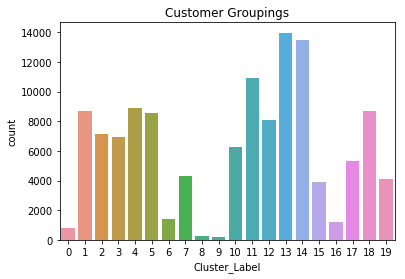

In [20]:
sns.countplot( x='Cluster_Label',data=customer_labels).set_title("Customer Groupings")
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

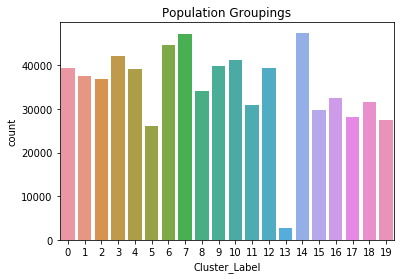

In [21]:
sns.countplot( x='Cluster_Label',data=gen_pop_labels).set_title("Population Groupings")
plt.show

In [53]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

bucket_count_pop = gen_pop_labels['Cluster_Label'].value_counts(sort=False,normalize=True)
bucket_count_cust = customer_labels['Cluster_Label'].value_counts(sort = False, normalize=True)

diff_cust = bucket_count_cust - bucket_count_pop
print(diff_cust)


0    -0.049692
1     0.016752
2     0.005308
3    -0.003714
4     0.016074
5     0.032294
6    -0.052426
7    -0.032348
8    -0.046889
9    -0.055745
10   -0.008045
11    0.044240
12    0.009007
13    0.109321
14    0.041612
15   -0.010969
16   -0.037147
17    0.002719
18    0.025664
19   -0.006015
Name: Cluster_Label, dtype: float64


In [ ]:
#The above normalized list displays the percentage of label observations for customers - the percentage of observations for the population
#The higher the positive percentage, the more the bucket has more customer % than population % and vice versa
#Therefore buckets 13, 11 & 14 are buckets where there is a higher proportion of customers than the population (overrepresented in the customer data)
#Therefore buckets 9, 6 & 0 are buckets where there is a higher proportion of population than customers (underrepresented in the customer data)

In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

#See above is just the most negative values

Yes we can.  Buckets 13, 11 & 14 are the groups that are a much higher percentage of the customer base relative to representation in the population base.  Given these groups have traditionally been more responsive it would make sense to target these demographics when advertising the product as they likely have a higher propensity to buy the product.

Conversely, buckets 9, 6 and 0 are relatively underrepresented in the customer base relative to population representation and might be less fruitful targets.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.